# App

In [1]:
from app import app

In [2]:
app.run_server(debug=True)

# Data
*create data for pages*

In [2]:
import os
os.chdir("..")

In [3]:
from pf_utils import PortfolioManager as PM 

WARNING (pytensor.tensor.blas): Using NumPy C-API based implementation for BLAS functions.


In [4]:
path_data = 'data'
path_tran = 'transaction'

In [5]:
file_cost='transaction_cost'

In [6]:
universe = 'UV_FUND'
fund = PM.create_universe(universe)
cost = PM.get_cost(universe, file=file_cost, path=path_tran)
fee = cost['fee']

64 securities from 2008-11-28 to 2024-11-29 uploaded.
REMINDER: 64 equities converted to daily (days in year: 365)
Daily metrics in Performance statistics must be meaningless
Price data loaded
Cost data transaction_cost_241217.csv loaded


In [7]:
df_prices = fund.df_prices
df_prices_fees = fund._get_prices_after_fee(df_prices, fee)

In [72]:
import pandas as pd

func = lambda x: [k for k,v in fund.security_names.items() if x.lower() in v.lower()]
cols = ['price', 'price_after_fees']
df_all = pd.DataFrame()
for i in range(2025,2060,5):
    tickers = func(str(i))
    df_a = pd.DataFrame()
    for j, df_p in enumerate([df_prices, df_prices_fees]):
        df = df_p[tickers].rename_axis('date')
        df = df.rename_axis('ticker',axis=1).unstack().to_frame(cols[j]).dropna()
        df_a = pd.concat([df_a, df], axis=1)
    df_a = df_a.assign(group=i).set_index('group', append=True).swaplevel(1,2).swaplevel(0,1)
    df_all = pd.concat([df_all, df_a])

df_all = (df_all.assign(ym=df_all.index.get_level_values("date").to_period('M'))
          .sort_index().groupby(['group','ticker','ym']).tail(1).drop('ym', axis=1))

In [73]:
file = 'fund_241229.csv'
path = 'pages'
df_all.to_csv(f'{path}/{file}')

In [51]:
file = 'fund_name_241230.csv'
path = 'pages'
pd.Series(fund.security_names).to_csv(f'{path}/{file}')

In [75]:
file = 'fund_241229.csv'
path = 'pages'
df_all = pd.read_csv(
    f'{path}/{file}',
    parse_dates=['date'],
    dtype={'ticker': str},
    index_col=['group', 'ticker', 'date']
)

In [ ]:
file = 'fund_name_241230.csv'
fund_name = pd.read_csv(f'{path}/{file}', dtype={'ticker': str}, index_col=[0]).to_dict()

In [8]:
os.chdir("pages")

# Lab

In [1]:
from dash import Dash, html, dcc, Output, Input
import pandas as pd
import dash_bootstrap_components as dbc
import dash_daq as daq
import json

# Load data
file = 'fund_241229.csv'
path = '.'
#path = '.'
df_prc = pd.read_csv(
    f'{path}/{file}',
    parse_dates=['date'],
    dtype={'ticker': str},
    index_col=['group', 'ticker', 'date']
)

file = 'fund_name_241230.csv'
fund_name = pd.read_csv(f'{path}/{file}', dtype={'ticker': str}, index_col=[0])
fund_name = fund_name.iloc[:,0].to_dict()

groups = df_prc.index.get_level_values('group').unique()
default_group = 2030
groups = [{'label': f'TDF{x}', 'value': x} for x in groups]

# Preprocess data to make it JSON-serializable and store it in a JavaScript variable
preprocessed_data = {}
df_prc.columns = ['수수료 적용 전', '수수료 적용 후']
cols = df_prc.columns
date_format = '%Y-%m-%d'
for group in groups:
    group_value = group['value']
    data = {'columns': list(cols), 'default': {}, 'compare': {}}
    start = None
    for col in cols:
        df_p = df_prc.loc[group_value, col].unstack('ticker').sort_index()
        df_p.columns = [fund_name[x] for x in df_p.columns]
        df_r = df_p.apply(lambda x: x.dropna().iloc[-1]/x.dropna().iloc[0]-1).mul(100).to_frame(col)
        data['default'][col] = {
            'history': df_p.round().to_dict('records'),
            'index': df_p.index.strftime(date_format).tolist(),
            'return': df_r.round(1).to_dict('records'),
            'ticker': df_r.index.tolist()
        }
        if start is None:
            start = df_p.apply(lambda x: x[x.notna()].index.min()).max()
        normalized_df = df_p.apply(lambda x: x / x.loc[start] * 1000).loc[start:]
        df_r_n = normalized_df.apply(lambda x: x.dropna().iloc[-1]/x.dropna().iloc[0]-1).mul(100).to_frame(col)
        data['compare'][col] = {
            'history': normalized_df.round().to_dict('records'),
            'index': normalized_df.index.strftime(date_format).tolist(),
            'return': df_r_n.round(1).to_dict('records'),
            'ticker': df_r.index.tolist()
        }
    preprocessed_data[group_value] = data


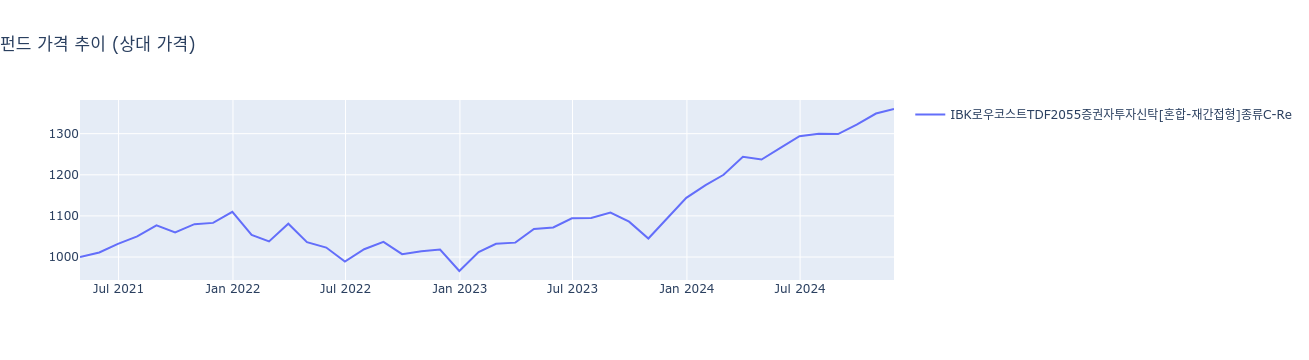

In [6]:
import plotly.graph_objects as go

def generate_plot(data, cost=False, compare=False):
    if not data or 'columns' not in data:
        return {'data': [], 'layout': {'title': 'No Data Available', 'height': 300}}
    
    cols = data['columns']  # Columns: ['price', 'price_after_fees']
    col = cols[1] if cost else cols[0]  # Select the column based on cost
    kind = 'compare' if compare else 'default'  # Default or compare data
    dat = data[kind][col]
    
    if not dat or 'history' not in dat or 'index' not in dat:
        return {'data': [], 'layout': {'title': 'No Data Available', 'height': 300}}
    
    # Prepare data for each ticker
    traces = []
    for ticker in dat['history'][0].keys():
        y_values = [row[ticker] for row in dat['history']]
        traces.append(go.Scatter(
            x=dat['index'],        # Dates from the index
            y=y_values,            # Price history for each ticker
            mode='lines',
            name=ticker ,           # Ticker as the legend name
            showlegend=True
        ))

    # Title logic
    title_base = '펀드 가격 추이'
    title_comp = '상대 가격' if compare else '펀드별 최근 결산 기준가격으로 계산'
    title_cost = '수수료 적용' if cost else None

    title = f"{title_base} ({title_comp}"
    title = f"{title}, {title_cost})" if title_cost else f"{title})"
    
    layout = go.Layout(
        title={'text': title, 'x': 0},
        hovermode='x',
    )
    
    return {'data': traces, 'layout': layout}


i = 2055
data = preprocessed_data[i]
result = generate_plot(data, cost=False, compare=True)
go.Figure(**result)

In [4]:
result

{'data': [Scatter({
      'mode': 'lines',
      'name': 'IBK로우코스트TDF2055증권자투자신탁[혼합-재간접형]종류C-Re',
      'x': [2021-04-30, 2021-05-31, 2021-06-30, 2021-07-31, 2021-08-31, 2021-09-30,
            2021-10-31, 2021-11-30, 2021-12-31, 2022-01-31, 2022-02-28, 2022-03-31,
            2022-04-30, 2022-05-31, 2022-06-30, 2022-07-31, 2022-08-31, 2022-09-30,
            2022-10-31, 2022-11-30, 2022-12-31, 2023-01-31, 2023-02-28, 2023-03-31,
            2023-04-30, 2023-05-31, 2023-06-30, 2023-07-31, 2023-08-31, 2023-09-30,
            2023-10-31, 2023-11-30, 2023-12-31, 2024-01-31, 2024-02-29, 2024-03-31,
            2024-04-30, 2024-05-31, 2024-06-30, 2024-07-31, 2024-08-31, 2024-09-30,
            2024-10-31, 2024-11-29],
      'y': [1000.0, 1011.0, 1032.0, 1050.0, 1077.0, 1060.0, 1080.0, 1083.0, 1110.0,
            1054.0, 1038.0, 1081.0, 1036.0, 1023.0, 989.0, 1019.0, 1037.0, 1007.0,
            1014.0, 1018.0, 966.0, 1012.0, 1032.0, 1035.0, 1068.0, 1072.0, 1094.0,
            1095.0, 1108.0,

## old

In [4]:
import pandas as pd

In [7]:
file = 'fund_name_241230.csv'
path = '.'

fund_name = pd.read_csv(f'{path}/{file}', dtype={'ticker': str}, index_col=[0])
fund_name = fund_name.iloc[:,0].to_dict()
fund_name

{'K55234DF2657': 'IBK로우코스트TDF2030증권자투자신탁[혼합-재간접형]종류C-Re',
 'K55234DF2459': 'IBK로우코스트TDF2035증권자투자신탁[혼합-재간접형]종류C-Re',
 'K55301BU6139': '미래에셋전략배분TDF2035혼합자산자투자신탁종류C-P2e',
 'K55105BU1161': '삼성한국형TDF2030증권투자신탁H[주식혼합-재간접형]Cpe(퇴직연금)',
 'K55210BU2385': '신한마음편한TDF2030증권투자신탁[주식혼합-재간접형](종류C-re)',
 'K55206C95800': '키움키워드림TDF2030증권투자신탁 1[혼합-재간접형]C-P2e(퇴직연금)',
 'K55210BU2435': '신한마음편한TDF2040증권투자신탁[주식혼합-재간접형](종류C-re)',
 'K55213C51890': '한화LIFEPLUSTDF2040증권자투자신탁(혼합-재간접형)C-RPe(퇴직연금)',
 'K55223BT1450': 'KB온국민TDF2040증권투자신탁(주식혼합-재간접형)C-퇴직e',
 'K55105BS5067': '삼성한국형TDF2040증권투자신탁H[주식혼합-재간접형]C-Pe',
 'K55101BY3944': '한국투자TIF알아서평생소득증권자투자신탁(채권혼합-재간접형)(C-Re)',
 'K55301BU5453': '미래에셋평생소득TIF혼합자산자투자신탁종류C-P2e',
 'K55301BU5479': '미래에셋전략배분TDF2045혼합자산자투자신탁 종류C-P2e',
 'K55210BU2450': '신한마음편한TDF2045증권투자신탁[주식혼합-재간접형](종류C-re)',
 'K55206C96311': '키움키워드림TDF2045증권투자신탁 1[혼합-재간접형]C-P2e(퇴직연금)',
 'KR5223AE3357': 'kb퇴직연금배당증권자투자신탁(주식)C-E',
 'K55365BT3694': 'kcgi코리아퇴직연금증권자투자신탁(주식)종류C-Pe2',
 'K55207BU0715': '교보악사파워인덱스증권자투자신탁1호(주식)C-P

In [20]:
import re


m = re.search(r'\d{4}', s)
func = lambda s: [s if x is None else s[:x.end()] for x in [re.search(r'\d{4}', s)]][0]

In [24]:
s = '신한마음편한TDF2040증권투자신탁[주식혼합-재간접형](종류C-re)'
#s = '신한마음편한TDF증권투자신탁[주식혼합-재간접형](종류C-re)'

func = lambda s: s[:m.end()] if (m := re.search(r'\d{4}', s)) else s

func(s)

'신한마음편한TDF2040'

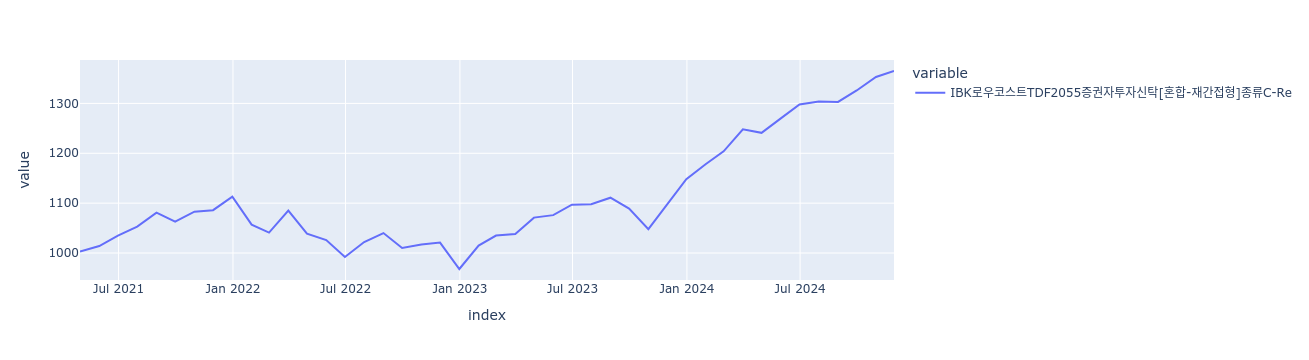

In [19]:
#i = 2050
i = 2055
data = preprocessed_data[i]
#data.keys()

col = '수수료 적용 전'
d = data['default'][col]['history']
i = data['default'][col]['index']
df = pd.DataFrame(d, index=i)

import plotly.express as px
px.line(df)

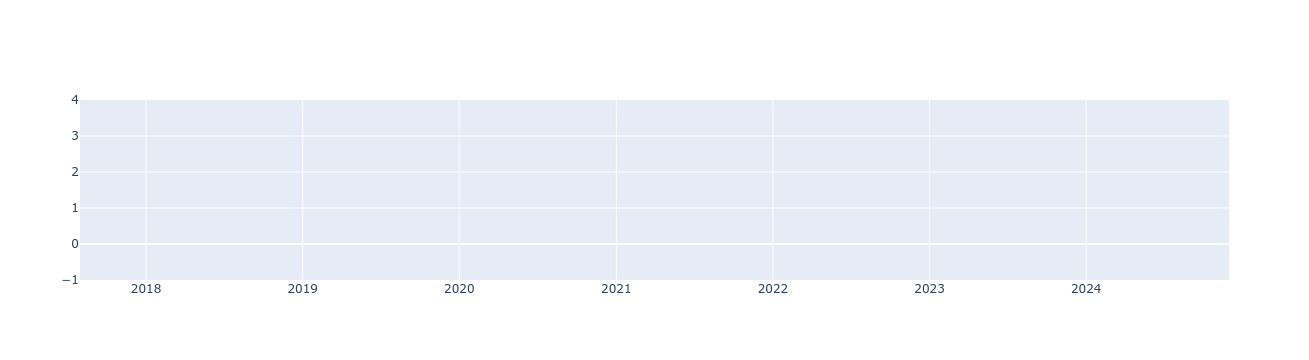

In [37]:
import plotly.graph_objects as go

i = 2050
data = preprocessed_data[i]
#data.keys()

col = '수수료 적용 전'
d = data['default'][col]['history']
i = data['default'][col]['index']

fig = go.Figure()

# Add traces
fig.add_trace(go.Scatter(x=i, y=d,
                    mode='lines',
                    #name='ticker'
                        )
             )
fig.show()

In [ ]:
# You can use Plotly's `plot` function to visualize the result
import plotly.offline as pyo
pyo.plot(result)

'temp-plot.html'

Opening in existing browser session.


In [38]:
d

[{'한국투자TDF알아서2050증권자투자신탁H(주식혼합-재간접형)(C-Re)': nan,
  '삼성한국형TDF2050증권투자신탁H[주식혼합-재간접형]Cpe(퇴직연금)': nan,
  '신한마음편한TDF2050증권투자신탁[주식혼합-재간접형](종류C-re)': nan,
  'KB온국민TDF2050증권자투자신탁(주식혼합-재간접형)(H)C-퇴직e': 942.0,
  'IBK로우코스트TDF2050증권자투자신탁[혼합-재간접형]종류C-Re': nan,
  '미래에셋전략배분TDF2050혼합자산자투자신탁종류C-P2e': nan},
 {'한국투자TDF알아서2050증권자투자신탁H(주식혼합-재간접형)(C-Re)': nan,
  '삼성한국형TDF2050증권투자신탁H[주식혼합-재간접형]Cpe(퇴직연금)': nan,
  '신한마음편한TDF2050증권투자신탁[주식혼합-재간접형](종류C-re)': nan,
  'KB온국민TDF2050증권자투자신탁(주식혼합-재간접형)(H)C-퇴직e': 936.0,
  'IBK로우코스트TDF2050증권자투자신탁[혼합-재간접형]종류C-Re': nan,
  '미래에셋전략배분TDF2050혼합자산자투자신탁종류C-P2e': nan},
 {'한국투자TDF알아서2050증권자투자신탁H(주식혼합-재간접형)(C-Re)': nan,
  '삼성한국형TDF2050증권투자신탁H[주식혼합-재간접형]Cpe(퇴직연금)': nan,
  '신한마음편한TDF2050증권투자신탁[주식혼합-재간접형](종류C-re)': nan,
  'KB온국민TDF2050증권자투자신탁(주식혼합-재간접형)(H)C-퇴직e': 954.0,
  'IBK로우코스트TDF2050증권자투자신탁[혼합-재간접형]종류C-Re': nan,
  '미래에셋전략배분TDF2050혼합자산자투자신탁종류C-P2e': nan},
 {'한국투자TDF알아서2050증권자투자신탁H(주식혼합-재간접형)(C-Re)': nan,
  '삼성한국형TDF2050증권투자신탁H[주식혼합-재간접형]Cpe(퇴직연금)': nan,
  '신한마음편한TDF2050증권투자신탁[주식혼합

In [ ]:
"""
            return {
                x: dat.index,        // Dates from the index
                y: yValues,          // Price history for each ticker
                type: 'scatter',
                mode: 'lines',
                name: ticker,        // Ticker as the legend name
                //color: ticker
            };
            """

"\n            return {\n                x: dat.index,        // Dates from the index\n                y: yValues,          // Price history for each ticker\n                type: 'scatter',\n                mode: 'lines',\n                name: ticker,        // Ticker as the legend name\n                //color: ticker\n            };\n            "

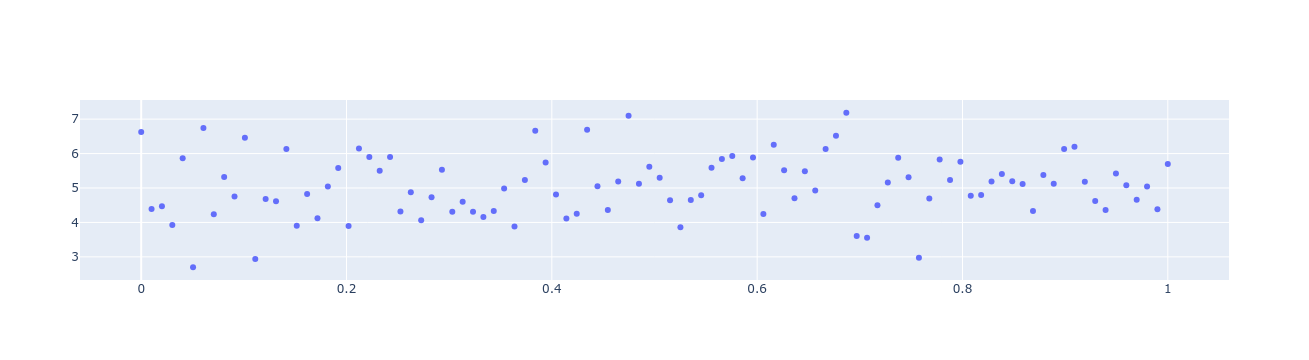

In [31]:
import plotly.graph_objects as go

# Create random data with numpy
import numpy as np
np.random.seed(1)

N = 100
random_x = np.linspace(0, 1, N)
random_y0 = np.random.randn(N) + 5
random_y1 = np.random.randn(N)
random_y2 = np.random.randn(N) - 5

fig = go.Figure()

# Add traces
fig.add_trace(go.Scatter(x=random_x, y=random_y0,
                    mode='markers',
                    name='markers'))


"""
            return {
                x: dat.index,        // Dates from the index
                y: yValues,          // Price history for each ticker
                type: 'scatter',
                mode: 'lines',
                name: ticker,        // Ticker as the legend name
                //color: ticker
            };
            """

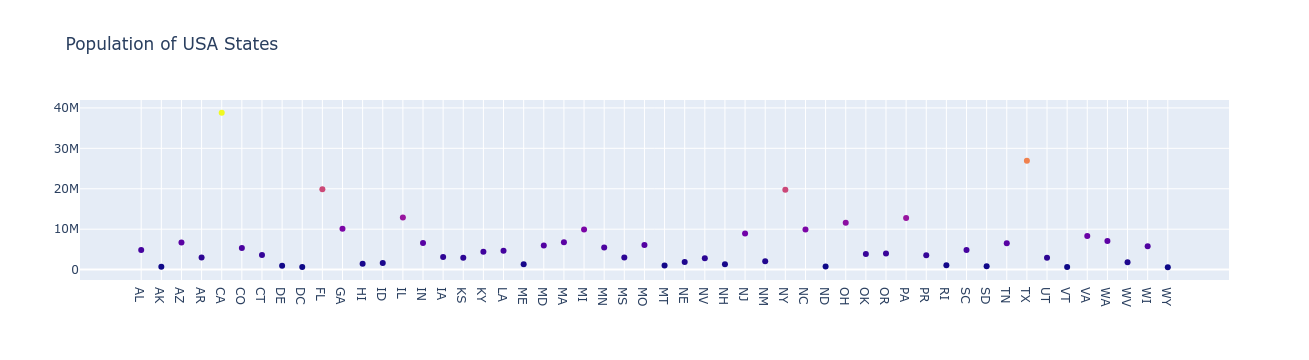

In [39]:
import plotly.graph_objects as go
import pandas as pd

data= pd.read_csv("https://raw.githubusercontent.com/plotly/datasets/master/2014_usa_states.csv")

fig = go.Figure(data=go.Scatter(x=data['Postal'],
                                y=data['Population'],
                                mode='markers',
                                marker_color=data['Population'],
                                text=data['State'])) # hover text goes here

fig.update_layout(title=dict(text='Population of USA States'))
fig.show()

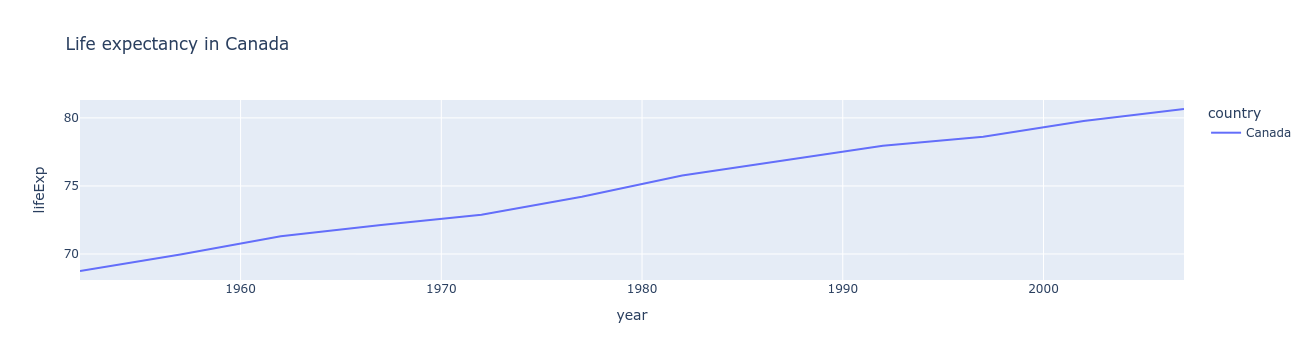

In [23]:
import plotly.express as px

df = px.data.gapminder().query("country=='Canada'")
fig = px.line(df, x="year", y="lifeExp", title='Life expectancy in Canada', color='country')
fig.show()

In [ ]:
df = px.data.gapminder().query("continent=='Oceania'")
fig = px.line(df, x="year", y="lifeExp", color='country')
fig.show()

In [10]:
from dash import Dash, html, dcc, Output, Input
import pandas as pd
import dash_bootstrap_components as dbc
import dash_daq as daq
import json

# Load data
file = 'fund_241229.csv'
path = '.'
#path = '.'
df_prc = pd.read_csv(
    f'{path}/{file}',
    parse_dates=['date'],
    dtype={'ticker': str},
    index_col=['group', 'ticker', 'date']
)

file = 'fund_name_241230.csv'
fund_name = pd.read_csv(f'{path}/{file}', dtype={'ticker': str}, index_col=[0])
fund_name = fund_name.iloc[:,0].to_dict()

groups = df_prc.index.get_level_values('group').unique()
default_group = 2030
groups = [{'label': f'TDF{x}', 'value': x} for x in groups]

# Initialize the Dash app
external_stylesheets = [dbc.themes.CERULEAN]
app = Dash(__name__, title="달달펀드",
           external_stylesheets=external_stylesheets)


tabs = dbc.Tabs([
    dbc.Tab(dcc.Graph(id='price-plot'), label='가격'),
    dbc.Tab(dcc.Graph(id='return-plot'), label='수익률'),
])

app.layout = dbc.Container([
    html.Br(),
    dbc.Row([
        dbc.Col(
            dcc.Dropdown(
                id='group-dropdown',
                options=groups,
                value=default_group,
                clearable=False,
            ),
            width=3
        ),
        dbc.Col(
            daq.BooleanSwitch(
                id='compare-boolean-switch',
                on=False
            ),
            width="auto"),
        dbc.Col(
            daq.BooleanSwitch(
                id='cost-boolean-switch',
                on=False
            ),
            width="auto"),
    ],
        justify="center",
        align="center",
        className="mb-3"
    ),
    dbc.Row(tabs),
    html.Br(),
    dcc.Store(id='price-data'),
    dbc.Tooltip(
        '상대 비교',
        target='compare-boolean-switch',
        placement='bottom'
    ),
    dbc.Tooltip(
        '수수료 적용',
        target='cost-boolean-switch',
        placement='bottom'
    )
])

# Preprocess data to make it JSON-serializable and store it in a JavaScript variable
preprocessed_data = {}
df_prc.columns = ['수수료 적용 전', '수수료 적용 후']
cols = df_prc.columns
date_format = '%Y-%m-%d'
for group in groups:
    group_value = group['value']
    data = {'columns': list(cols), 'default': {}, 'compare': {}}
    start = None
    for col in cols:
        df_p = df_prc.loc[group_value, col].unstack('ticker').sort_index()
        df_p.columns = [fund_name[x] for x in df_p.columns]
        df_r = df_p.apply(lambda x: x.dropna().iloc[-1]/x.dropna().iloc[0]-1).mul(100).to_frame(col)
        data['default'][col] = {
            'history': df_p.round().to_dict('records'),
            'index': df_p.index.strftime(date_format).tolist(),
            'return': df_r.round(1).to_dict('records'),
            'ticker': df_r.index.tolist()
        }
        if start is None:
            start = df_p.apply(lambda x: x[x.notna()].index.min()).max()
        normalized_df = df_p.apply(lambda x: x / x.loc[start] * 1000).loc[start:]
        df_r_n = normalized_df.apply(lambda x: x.dropna().iloc[-1]/x.dropna().iloc[0]-1).mul(100).to_frame(col)
        data['compare'][col] = {
            'history': normalized_df.round().to_dict('records'),
            'index': normalized_df.index.strftime(date_format).tolist(),
            'return': df_r_n.round(1).to_dict('records'),
            'ticker': df_r.index.tolist()
        }
    preprocessed_data[group_value] = data

# Inject preprocessed data as JSON in the client
preprocessed_data_json = json.dumps(preprocessed_data)
app.index_string = f"""
<!DOCTYPE html>
<html>
    <head>
        {{%metas%}}
        <title>{{%title%}}</title>
        <link rel="icon" type="image/x-icon" href="/assets/favicon.ico">
        {{%css%}}
    </head>
    <body>
        <script>
            var preprocessedData = {preprocessed_data_json};
        </script>
        {{%app_entry%}}
        {{%config%}}
        {{%scripts%}}
        {{%renderer%}}
    </body>
</html>
"""


# Client-side callback for price data
app.clientside_callback(
    """
    function(group) {
        return preprocessedData[group];
    }
    """,
    Output('price-data', 'data'),
    Input('group-dropdown', 'value')
)


app.clientside_callback(
    """
    function(data, cost, compare) {
        if (!data || !data.columns) {
            return {data: [], layout: {title: 'No Data Available', height: 300}};
        }

        const cols = data.columns; // Columns: ['price', 'price_after_fees']
        const col = cost ? cols[1] : cols[0]; // Select the column based on cost
        const kind = compare ? 'compare' : 'default'; // Default or compare data
        const dat = data[kind][col];

        if (!dat || !dat.history || !dat.index) {
            return {data: [], layout: {title: 'No Data Available', height: 300}};
        }

        // Prepare data for each ticker
        const traces = Object.keys(dat.history[0]).map(ticker => {
            const yValues = dat.history.map(row => row[ticker]);
            return {
                x: dat.index,        // Dates from the index
                y: yValues,          // Price history for each ticker
                type: 'scatter',
                mode: 'lines',
                name: ticker,        // Ticker as the legend name
                showlegend: true
            };
        });

        // Title logic
        const titleBase = '펀드 가격 추이';
        const titleComp = compare ? '상대 가격' : '펀드별 최근 결산 기준가격으로 계산';
        const titleCost = cost ? '수수료 적용' : null;

        let title = `${titleBase} (${titleComp}`;
        title = titleCost ? `${title}, ${titleCost})` : `${title})`;

        return {
            data: traces,
            layout: {
                title: { text: title, x: 0 },
                hovermode: 'x',
                yaxis: { title: '기준가격' },
                xaxis: {
                    rangeselector: {
                        buttons: [
                            {
                                count: 3,
                                label: "3y",
                                step: "year",
                                stepmode: "backward"
                            },
                            {
                                step: "all",
                                label: "All"
                            }
                        ]
                    },
                    rangeslider: {
                        visible: true
                    },
                    type: "date"
                }
            }
        };
    }
    """,
    Output('price-plot', 'figure'),
    Input('price-data', 'data'),
    Input('cost-boolean-switch', 'on'),
    Input('compare-boolean-switch', 'on')
)


app.clientside_callback(
    """
    function(data, cost, compare) {
        if (!data || !data.columns) {
            return {data: [], layout: {title: 'No Data Available', height: 300}};
        }

        const cols = data.columns; // Columns: ['price', 'price_after_fees']
        const sel = cost ? cols[1] : cols[0]; // Selected column based on cost
        const kind = compare ? 'compare' : 'default'; // Default or compare data
        const dat = data[kind];

        if (!dat[cols[0]] || !dat[cols[1]] || !dat[cols[0]].return || !dat[cols[0]].ticker) {
            return {data: [], layout: {title: 'No Data Available', height: 300}};
        }

        const tickers = dat[cols[0]].ticker; // Tickers for x-axis
        const returnPrice = dat[cols[0]].return; // Returns for 'price'
        const returnFees = dat[cols[1]].return; // Returns for 'price_after_fees'

        // Generate bar traces for both columns, always in the same order
        const traces = [
            {
                x: tickers,
                y: returnPrice.map(r => r[cols[0]]),
                type: 'bar',
                name: cols[0], // Label for 'price'
                opacity: cost ? 0.3 : 0.6, // Fade when cost is True
                marker: {
                    line: { color: 'black', width: 1 }
                }
            },
            {
                x: tickers,
                y: returnFees.map(r => r[cols[1]]),
                type: 'bar',
                name: cols[1], // Label for 'price_after_fees'
                opacity: cost ? 0.6 : 0.3, // Fade when cost is False
                marker: {
                    line: { color: 'black', width: 1 }
                }
            }
        ];

        // Set title dynamically based on compare switch
        let title;
        if (compare) {
            const dates = dat[sel].index;
            const dt0 = new Date(Math.min(...dates.map(d => new Date(d).getTime()))).toISOString().slice(0, 10);
            const dt1 = new Date(Math.max(...dates.map(d => new Date(d).getTime()))).toISOString().slice(0, 10);
            title = `펀드 수익률 (${dt0} ~ ${dt1})`;
        } else {
            title = '펀드 수익률 (펀드별 설정일 이후)';
        }

        return {
            data: traces,
            layout: {
                title: { text: title, x: 0 }, // Align title to the left
                //xaxis: { title: 'Tickers' },
                yaxis: { title: '수익률(%)' },
                barmode: 'group', // Grouped bar chart
                //height: 400,
                hovermode: 'x',
                //hovertemplate='%{y:.0f}%'
            }
        };
    }
    """,
    Output('return-plot', 'figure'),
    Input('price-data', 'data'),
    Input('cost-boolean-switch', 'on'),
    Input('compare-boolean-switch', 'on')
)


if __name__ == '__main__':
    app.run_server(debug=True)